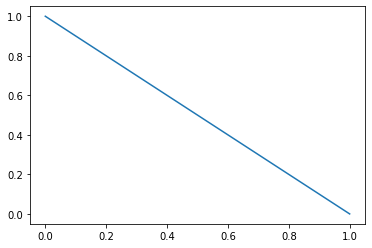

(-75, -56)
Import of general_pyNN.PYNNBackend failed due to:
No module named 'pyNN'


In [1]:
import sys
import traceback
import matplotlib.pyplot as plt

%matplotlib inline
plt.plot([0,1],[1,0])
plt.show()
class TracePrints(object):
    def __init__(self):
        self.stdout = sys.stdout
    def write(self,s):
        self.stdout.write("Writing %r\n" % s)
        traceback.print_stack(file=self.stdout)

from neuronunit.optimisation import get_neab
from neuronunit.optimisation.optimization_management import switch_logic, inject_and_plot_model


INFO:root:test
INFO:root:test


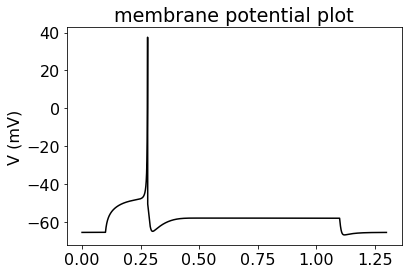

In [2]:
import hide_imports

edges = hide_imports.model_parameters.MODEL_PARAMS['RAW']
import numpy as np
params = {k:np.mean(v) for k,v in edges.items()}
vm,plt = inject_and_plot_model(params,'RAW')


In [3]:

import collections
from IPython.display import HTML, display

# Fast spiking cannot be reproduced as it requires modifications to the standard Izhi equation,
# which are expressed in this mod file.
# https://github.com/OpenSourceBrain/IzhikevichModel/blob/master/NEURON/izhi2007b.mod

from collections import OrderedDict
type2007 = collections.OrderedDict([
  #              C    k     vr  vt vpeak   a      b   c    d  celltype
  ('RS',        (100, 0.7,  -60, -40, 35, 0.03,   -2, -50,  100,  1)),
  ('IB',        (150, 1.2,  -75, -45, 50, 0.01,   5, -56,  130,   2)),
  ('CH',        (50,  1.5,  -60, -40, 25, 0.03,   1, -40,  150,   3)),
  ('LTS',       (100, 1.0,  -56, -42, 40, 0.03,   8, -53,   20,   4)),
  ('FS',        (20,  1.0,  -55, -40, 25, 0.2,   -2, -45,  -55,   5)),
  ('TC',        (200, 1.6,  -60, -50, 35, 0.01,  15, -60,   10,   6)),
  ('TC_burst',  (200, 1.6,  -60, -50, 35, 0.01,  15, -60,   10,   6)),
  ('RTN',       (40,  0.25, -65, -45,  0, 0.015, 10, -55,   50,   7)),
  ('RTN_burst', (40,  0.25, -65, -45,  0, 0.015, 10, -55,   50,   7))])

import numpy as np
param_dict = OrderedDict([(k,[]) for k in ['C','k','vr','vt','vPeak','a','b','c','d']])
#OrderedDict
for i,k in enumerate(param_dict.keys()):
    for v in type2007.values():
        param_dict[k].append(v[i])

explore_param = {k:(np.min(v),np.max(v)) for k,v in param_dict.items()}
param_ranges = OrderedDict(explore_param)


#IB = mparams[param_dict['IB']]
RS = {}
IB = {}
TC = {}
CH = {}
RTN_burst = {}
for k,v in param_dict.items():
    RS[k] = v[0]
    IB[k] = v[1]
    CH[k] = v[2]
    TC[k] = v[5]
    RTN_burst[k] = v[-2]

known_parameters = {}
known_parameters['RS'] = RS
known_parameters['IB'] = IB
known_parameters['CH'] = CH
known_parameters['TC'] = TC
known_parameters['RTN_burst'] = RTN_burst


In [4]:
from neuronunit.optimisation.optimization_management import OptMan,TSD,dtc_to_rheo
from neuronunit.optimisation.data_transport_container import DataTC
import dask.bag as db

test_frame = get_neab.process_all_cells()
tt = test_frame['Neocortex pyramidal cell layer 5-6']#
tt = switch_logic(tt)
not_suite = TSD({t.name:t for t in tt.tests})

#not_suite.optimize()
print(tt[0].passive)
print(tt[0].active)
from neuronunit.models import StaticModel

dtcpop = []
import copy

def model_test_eval(tests,backend,params):
    from sciunit import TestSuite

    if type(tests) is TestSuite:
        not_suite = TSD({t.name:t for t in tests.tests})
    
    OM = OptMan(tests, backend = backend)
    tests.use_rheobase_score = True

    dtc = DataTC()
    dtc.attrs = params
    print(params)
    dtc.backend = backend
    #dtc.cell_name = 'vanilla'
    dtc.tests = copy.copy(not_suite)
    dtc = dtc_to_rheo(dtc)
    print(dtc.rheobase)
    if dtc.rheobase is not None:
        dtc.tests = dtc.format_test()
        dtc = list(map(OM.elephant_evaluation,[dtc]))[0]
    return dtc

edges = hide_imports.model_parameters.MODEL_PARAMS['HH']
import numpy as np
params = {k:np.mean(v) for k,v in edges.items()}
dtc = model_test_eval(tt,"HH",params)

display(dtc.obs_preds)
for k,v in known_parameters.items():
    dtc = model_test_eval(tt,"RAW",v)
    if hasattr(dtc,'obs_preds'):
        display(dtc.obs_preds)
        dtcpop.append(dtc)
from neuronunit.optimisation.optimization_management import inject_and_plot_model


for d in dtcpop:
    print("\n")
    print(d.SA)
    inject_and_plot_model(d)
    display(d.obs_preds)

INFO:numba.transforms:finding looplift candidates


False
True
{'E_L': -54.387, 'E_K': -77.0, 'E_Na': 50.0, 'g_L': 0.3, 'g_K': 36.0, 'g_Na': 120.0, 'C_m': 1.0, 'vr': -65.0, 'Vr': -54.387}
2.240341901779175 pA


,RheobaseTest,InputResistanceTest,TimeConstantTest,CapacitanceTest,RestingPotentialTest,InjectedCurrentAPWidthTest,InjectedCurrentAPAmplitudeTest,InjectedCurrentAPThresholdTest,total
observations,213.849583333333 pA,120.672073643411 Mohm,15.7342424242424 ms,150.584166666667 pF,-68.2481434599156 mV,1.20769387755102 ms,80.4351020408164 mV,-42.7357232704403 mV,NaN
predictions,2.240341901779175 pA,2268.76388551764 Mohm,0.0015498821098735049 ms,0.0006831394486517421 pF,-64.99637933118947 mV,1.0810000000000002 ms,68.6624136324269 mV,-46.15895274233281 mV,NaN
scores,-1.24146,27.6698,-2.15174,-1.07803,0.497794,-0.237101,-0.923435,-0.425736,34.22506


{'C': 100, 'k': 0.7, 'vr': -60, 'vt': -40, 'vPeak': 35, 'a': 0.03, 'b': -2, 'c': -50, 'd': 100}
51.7930805683136 pA


,RheobaseTest,InputResistanceTest,TimeConstantTest,CapacitanceTest,RestingPotentialTest,InjectedCurrentAPWidthTest,InjectedCurrentAPAmplitudeTest,InjectedCurrentAPThresholdTest,total
observations,213.849583333333 pA,120.672073643411 Mohm,15.7342424242424 ms,150.584166666667 pF,-68.2481434599156 mV,1.20769387755102 ms,80.4351020408164 mV,-42.7357232704403 mV,NaN
predictions,51.7930805683136 pA,79.63401632571134 Mohm,9.822997253629314 ms,123.35177486781829 pF,-60.0 mV,0.68 ms,48.463136305306776 mV,-13.463136305306776 mV,NaN
scores,-0.950743,-0.528615,-0.808472,-0.194957,1.26266,-0.987551,-2.50784,3.64054,10.881378


{'C': 150, 'k': 1.2, 'vr': -75, 'vt': -45, 'vPeak': 50, 'a': 0.01, 'b': 5, 'c': -56, 'd': 130}
304.73833680152893 pA


,RheobaseTest,InputResistanceTest,TimeConstantTest,CapacitanceTest,RestingPotentialTest,InjectedCurrentAPWidthTest,InjectedCurrentAPAmplitudeTest,InjectedCurrentAPThresholdTest,total
observations,213.849583333333 pA,120.672073643411 Mohm,15.7342424242424 ms,150.584166666667 pF,-68.2481434599156 mV,1.20769387755102 ms,80.4351020408164 mV,-42.7357232704403 mV,NaN
predictions,304.73833680152893 pA,24.231421892547186 Mohm,2.7843503429733136 ms,114.90660165632669 pF,-75.0 mV,0.51 ms,67.18604573756164 mV,-17.18604573756165 mV,NaN
scores,0.533221,-1.24226,-1.77114,-0.255416,-1.0336,-1.3057,-1.03924,3.17753,10.358106


{'C': 50, 'k': 1.5, 'vr': -60, 'vt': -40, 'vPeak': 25, 'a': 0.03, 'b': 1, 'c': -40, 'd': 150}
None
{'C': 200, 'k': 1.6, 'vr': -60, 'vt': -50, 'vPeak': 35, 'a': 0.01, 'b': 15, 'c': -60, 'd': 10}
74.86642599105835 pA


,RheobaseTest,InputResistanceTest,TimeConstantTest,CapacitanceTest,RestingPotentialTest,InjectedCurrentAPWidthTest,InjectedCurrentAPAmplitudeTest,InjectedCurrentAPThresholdTest,total
observations,213.849583333333 pA,120.672073643411 Mohm,15.7342424242424 ms,150.584166666667 pF,-68.2481434599156 mV,1.20769387755102 ms,80.4351020408164 mV,-42.7357232704403 mV,NaN
predictions,74.86642599105835 pA,31.739282815024687 Mohm,1516.8643750355518 ms,47791.38784816841 pF,-60.0 mV,0.67 ms,57.366983205724566 mV,-22.366983205724562 mV,NaN
scores,-0.815378,-1.14555,205.307,341.062,1.26266,-1.00627,-1.80943,2.53319,554.941327


{'C': 40, 'k': 0.25, 'vr': -65, 'vt': -45, 'vPeak': 0, 'a': 0.015, 'b': 10, 'c': -55, 'd': 50}
None


OrderedDict([('RheobaseTest', -0.9507431443882878), ('InputResistanceTest', -0.5286150515729994), ('TimeConstantTest', -0.8084719969036545), ('CapacitanceTest', -0.1949572913990462), ('RestingPotentialTest', 1.2626613905837791), ('InjectedCurrentAPWidthTest', -0.9875510589764733), ('InjectedCurrentAPAmplitudeTest', -2.507840590669025), ('InjectedCurrentAPThresholdTest', 3.640537422322158)])


TypeError: inject_and_plot_model() missing 1 required positional argument: 'backend'

In [ ]:
param_edges = hide_imports.model_parameters.MODEL_PARAMS['RAW']

results = not_suite.optimize(param_edges,backend="RAW",protocol={'allen': False, 'elephant': True},MU=8,NGEN=8)
not_suite.display()
#display(results['pf'][0].dtc.obs_preds)

In [ ]:
dtc[0].obs_preds




In [ ]:
param_edges = hide_imports.model_parameters.MODEL_PARAMS['HH']

results = not_suite.optimize(param_edges,backend="HH",protocol={'allen': False, 'elephant': True},MU=8,NGEN=8)
display(results['pf'][0].dtc.obs_preds)#not_suite.display()


In [ ]:
#SA = 

sub_tests = [tt.tests[0],tt.tests[5],tt.tests[6],tt.tests[7]]
#for x in tt.tests:

for t in sub_tests:
    print(t.params)    
    #print(dir(t))
    #t.setup_protocol(model)
    #print(x.passive)

In [ ]:
def get_table(tests,scores=None):
    temp = {t.name:t for t in tests}
    from neuronunit.optimisation.optimization_management import OptMan
    import pandas as pd
    obs = {}
    pred = {}
    scores_ = {}
    similarity,lps,rps =  OptMan.closeness(OptMan,temp,temp)
    for k,p,o in zip(list(similarity.keys()),lps,rps):
        obs[k] = o
        pred[k] = p
        scores_[k] = float(scores[k].score)

    obs_preds = pd.DataFrame([obs,pred,scores_],index=['observations','predictions','scores'])

    return obs_preds


In [ ]:
#from neuronunit.models.very_reduced_sans_lems import VeryReducedModel
#from neuronunit.optimisation import get_neab
model = None
import copy
from neuronunit.models.very_reduced_sans_lems import VeryReducedModel

model = VeryReducedModel(backend = str('HH'))
edges = hide_imports.model_parameters.MODEL_PARAMS['HH']
import numpy as np
params = {k:np.mean(v) for k,v in edges.items()}
model.set_attrs(params)

tests = get_neab.process_all_cells()

#score = tests['Neocortex pyramidal cell layer 5-6'].tests[1].judge(model)
#score = tests['Neocortex pyramidal cell layer 5-6'].tests[0].judge(model)
HH_tables = []
for t in tests.values():
    SA = t.judge(model)
    temp = copy.copy(t)
    table = get_table(temp,scores=SA)
    display(table)
    HH_tables.append(table)
    #break
table
print(SA)

In [ ]:
HH_tables = []
for t in tests.values():
    for t_instance in t:
        print(t_instance.params)
    #SA = t.judge(model)
    #temp = copy.copy(t)
    #table = get_table(temp)
    #display(table)
    #HH_tables.append(table)
    #break
#table
#print(SA)

In [ ]:
for t in HH_tables:
    try:
        display(t)
    except:
        pass

In [ ]:
#for mparams in [RS,IB,CH,TC,RTN_burst]:
model = None
model = VeryReducedModel(backend = str('RAW'))
model.set_attrs(RS)
SA = tests['Neocortex pyramidal cell layer 5-6'].judge(model)
temp = copy.copy(tests['Neocortex pyramidal cell layer 5-6'])
table = get_table(temp)
display(table)
#HH_tables.append(table)
#display(tables)

In [ ]:
import copy
tables = []
for mparams in [RS,IB,CH,TC,RTN_burst]:
    model = None
    model = VeryReducedModel(backend = str('RAW'))
    model.set_attrs(mparams)
    SA = tests['Neocortex pyramidal cell layer 5-6'].judge(model)
    temp = copy.copy(tests['Neocortex pyramidal cell layer 5-6'])
    try:
        table = get_table(temp)
        tables.append(table)
    except:
        tables.append(SA)


In [ ]:
#print(tables[0])

for t in tables:
    try:
        display(t)
    except:
        print(t)
    #print(t)

In [ ]:
for table in HH_tables:
    display(table)

In [ ]:

plt.clf()
import copy
%matplotlib inline

def permutations(use_test,backend):
    use_test = hide_imports.TSD(use_test)
    use_test.use_rheobase_score = True
    edges = hide_imports.model_parameters.MODEL_PARAMS[backend]
    ga_out0 = use_test.optimize(edges,backend=backend,\
        protocol={'allen': False, 'elephant': True}, MU=8,NGEN=1)
    ga_out1 =  use_test.optimize(edges,backend=backend,\
        protocol={'allen': False, 'elephant': True},\
            MU=8,NGEN=8,seed_pop=ga_out0['pf'][0])

    
    dtc = ga_out1['pf'][0].dtc
    vm,plt = hide_imports.inject_and_plot_model(dtc.attrs,dtc.backend)
    plt.show()
    return dtc, ga_out1['DO'], vm


In [ ]:
test_frame = hide_imports.get_neab.process_all_cells()
test_frame.pop('Olfactory bulb (main) mitral cell',None)
OMObjects = []
backends = ["RAW","HH","ADEXP","BHH"]
t = test_frame['Neocortex pyramidal cell layer 5-6']



In [ ]:

backends = ["RAW","HH"]#,"ADEXP","BHH"]


for t in test_frame.values():
    b = backends[0]
    (dtc,DO,vm) = permutations(copy.copy(t),b)
    display(dtc.SM)
    display(dtc.obs_preds)
    plt.plot(vm.times,vm.magnitude)
    plt.show()

    break
    




In [ ]:
for t in test_frame.values():
    b = backends[1]
    (dtc,DO,vm) = permutations(copy.copy(t),b)
    display(dtc.SM)
    display(dtc.obs_preds)
    plt.plot(vm.times,vm.magnitude)
    plt.show()
    break


In [ ]:
for t in test_frame.values():
    #for b in backends:
    b = backends[2]
    (dtc,DO,vm) = permutations(copy.copy(t),b)
    display(dtc.SM)
    display(dtc.obs_preds)
    plt.plot(vm.times,vm.magnitude)
    plt.show()


In [ ]:
for t in test_frame.values():
    #for b in backends:
    b = backends[3]
    (dtc,DO,vm) = permutations(copy.copy(t),b)
    display(dtc.SM)
    display(dtc.obs_preds)
    plt.plot(vm.times,vm.magnitude)
    plt.show()


In [ ]:
(dtc,DO) = permutations(test_frame['Neocortex pyramidal cell layer 5-6'],"ADEXP")
display(dtc.SM)
display(dtc.obs_preds)

In [ ]:

backends = ["RAW","HH","BHH"]  



#for b in backends:
(dtc,DO) = permutations(test_frame['Neocortex pyramidal cell layer 5-6'],"RAW")


In [ ]:
backends = iter(["RAW","HH","BHH"])


from IPython.display import HTML, display

for b in backends:
    (dtc,DO) = permutations(test_frame['Neocortex pyramidal cell layer 5-6'],b)
    display(dtc.SM)
    display(dtc.obs_preds)



In [ ]:
#test_frame['Neocortex pyramidal cell layer 5-6']